# 1 Monte-Carlo Simulation

In [1]:
# imports

import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt
import sklearn

## 1.1 Data Creation and Visualization

We have to fin a transformation between uniformly drawn random numbers generated by numpy and our desired distribution. We can use inverse transform sampling to derive the required distribution.

(i) $f(X=x|Y=0)=2-2x$

First, we have to compute the cumulative distribution function (CDF):
$$
F(x)=1 - \int_{x}^{1}\mathrm{d}x\ f(x) = 2x-x^2
$$
We then compute the inverse:
$$
F(F^{-1}(u))=u 
$$
$$
\Leftrightarrow F^{-1}(u)=1\pm\sqrt{1-u}
$$
Since $u,x \in [0,1]$, we have to apply $x=F^{-1}(u)=1-\sqrt{1-u}$, where $u$ is a uniformly generated random number.

(ii) $f(X=x|Y=1)=2x$

Here, the CDF is simply
$$
F(x)= x^2.
$$
Thus, 
$$
F^{-1}(u)=\sqrt{u}. 
$$

Text(0.5,1,'histogram of generated features X')

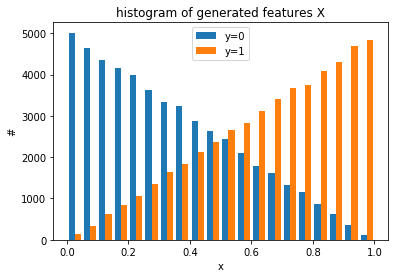

In [2]:
# define data generating function
def create_data(N):
    
    # first, draw labels from {0,1} with prior probability 0.5
    labels = np.random.randint(0,2,N)

    # sample features
    # draw N numbers from uniform distribution
    U = np.random.rand(N)
    features = np.ones(N)

    for i in range(N):
        # for N samples
        if labels[i] == 0:
            # if the label Y equals 0 sample according to the first likelihood
            # therefore transform uniform random numbers
            features[i] = 1-(1-U[i])**0.5
        else:
            # if the label Y equals 1 sample according to the second likelihood
            features[i] = U[i]**0.5 

    return features, labels


# demonstrate data generation
N = 100000
features, labels = create_data(N)

# histogram plotting
plt.hist(np.array([features[labels==0],features[labels==1]]),bins=20,label=['y=0','y=1'])
plt.legend()
plt.xlabel('x')
plt.ylabel('#')
plt.title('histogram of generated features X')

## 1.2 Classifcation by Thresholding

In [3]:
# define parameter space
x_t_lst = [0.2,0.5,0.6]
M = [int(10**i) for i in np.arange(1,4.5,0.5)]

# define rules
def f_A (x,x_t): 
    if x < x_t:
        y = 0
    else:
        y = 1
    return y

def f_B (x,x_t): 
    if x < x_t:
        y = 1
    else:
        y = 0
    return y

f_C = np.random.randint(0,2)

f_D = 1


# define error rate function
def p_err (predicted,true_label):
    return len(np.where(predicted!=true_label)[0])*len(predicted)**-1

# generate test sets
test_sets = [[create_data(m) for i in range(10)] for m in M]

# compute error rates of test sets
p_err_A = [[[p_err([f_A(t,x_t) for t in test_set[0]],test_set[1]) 
            for test_set in sets_M] 
            for sets_M in test_sets]
            for x_t in x_t_lst]
p_err_A = [np.mean(p_err_A,axis=2),np.std(p_err_A,axis=2)]

p_err_B = [[[p_err([f_B(t,x_t) for t in test_set[0]],test_set[1]) 
            for test_set in sets_M] 
            for sets_M in test_sets]
            for x_t in x_t_lst]
p_err_B = [np.mean(p_err_B,axis=2),np.std(p_err_B,axis=2)]

p_err_C = [[p_err([f_C for t in test_set[0]],test_set[1]) 
            for test_set in sets_M] 
            for sets_M in test_sets]
p_err_C = [np.mean(p_err_C,axis=1),np.std(p_err_C,axis=1)]

p_err_D = [[p_err([f_D for t in test_set[0]],test_set[1]) 
            for test_set in sets_M] 
            for sets_M in test_sets]
p_err_D = [np.mean(p_err_D,axis=1),np.std(p_err_D,axis=1)]

Text(0.5,1,'error rate for rule D')

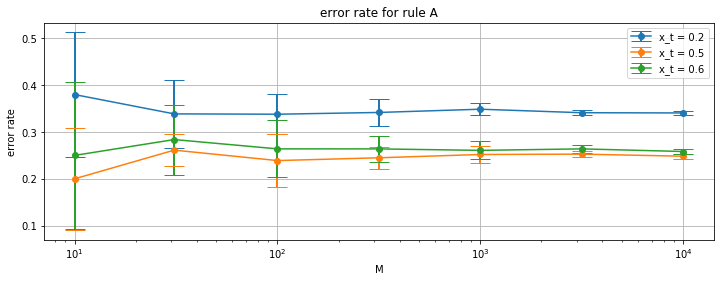

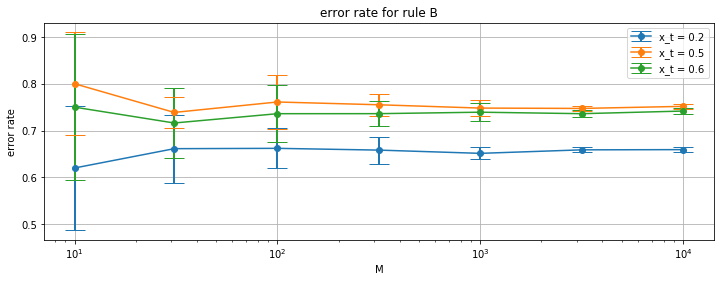

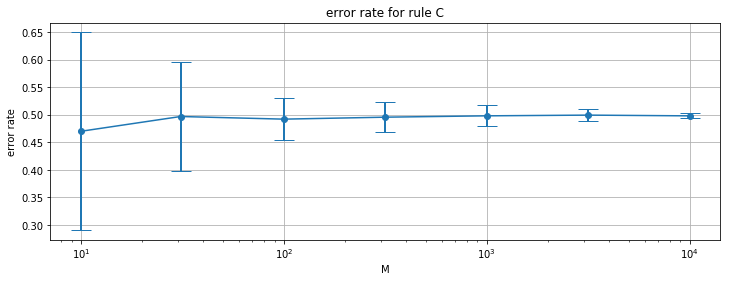

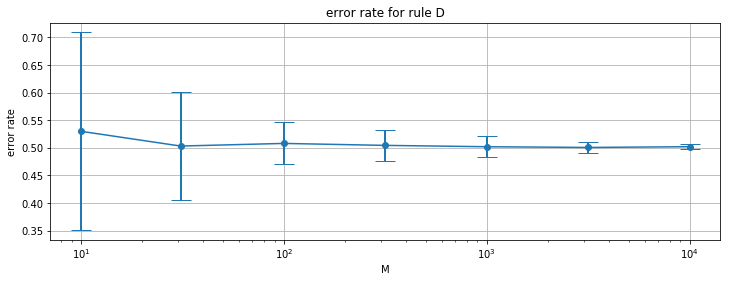

In [4]:
# plotting of results

# plot results rule A
plt.figure(figsize=(12,4))
plt.semilogx()

for i in range(len(x_t_lst)):
    plt.errorbar(M,p_err_A[0][i],yerr=p_err_A[1][i],elinewidth=2,capsize=10,fmt='o-', label = 'x_t = %0.1f'%x_t_lst[i])

plt.grid()
plt.legend()
plt.ylabel('error rate')
plt.xlabel('M')
plt.title('error rate for rule A')

# plot results rule B
plt.figure(figsize=(12,4))
plt.semilogx()

for i in range(len(x_t_lst)):
    plt.errorbar(M,p_err_B[0][i],yerr=p_err_B[1][i],elinewidth=2,capsize=10,fmt='o-', label = 'x_t = %0.1f'%x_t_lst[i])

plt.grid()
plt.legend()
plt.ylabel('error rate')
plt.xlabel('M')
plt.title('error rate for rule B')

# plot results rule C
plt.figure(figsize=(12,4))
plt.semilogx()

plt.errorbar(M,p_err_C[0],yerr=p_err_C[1],elinewidth=2,capsize=10,fmt='o-')

plt.grid()
plt.ylabel('error rate')
plt.xlabel('M')
plt.title('error rate for rule C')

# plot results rule D
plt.figure(figsize=(12,4))
plt.semilogx()

plt.errorbar(M,p_err_D[0],yerr=p_err_D[1],elinewidth=2,capsize=10,fmt='o-')

plt.grid()
plt.ylabel('error rate')
plt.xlabel('M')
plt.title('error rate for rule D')

The plots above show the error rates of the four rules. The standard deviation decreases with $1/\sqrt{M}$.  The error rates converge for large number of monte carlo runs M. The error rates are in agreement with the predicted values. Rule C and D are independant of the treshold. Thus, just one line appears in the plot. As one would expect, both converge to an error rate of 0.5. Rule A arrives at the minimal error of 0.25 for $x_{\mathrm{t}} = 0.5$.

## 1.3 Nearest Neighbor Classifcation

In [5]:
# implement NN 
def nearest_neighbor(features,training_set):

    labels = np.ones(len(features))

    for i in range(len(features)):
        # for all x in the vector of new features
        # compute the differences to all training features
        # get the index of the minimal difference
        # assign the label of the minimal distance to the new feature
        labels[i] = training_set[1][np.argmin(np.abs(training_set[0] - features[i]))]
        
    return features,labels

# define rejection method function
def rejection_method(training_set,N):
    active_training_set = [[training_set[0][0]],[training_set[1][0]]]
    i = 0 # index
    n = 1 # size of active set
    while n < N:
        # active set size smaller requeired set size
        
        i = i+1
        # we use NN to discrimate, as we can directly use the function for any N
        predicted = nearest_neighbor([training_set[0][i]],active_training_set)[1]
        
        if predicted == training_set[1][i]:
            # reject
            do_nothing = 0
        
        else:
            # append to active training set
            active_training_set[0].append(training_set[0][i])
            active_training_set[1].append(training_set[1][i])
            
            n = n+1    
        
    return active_training_set

In [25]:
# create dataset N=2
training_sets = [create_data(10000) for i in range(100)]

N = 2
active_TSs = [rejection_method(TS,N) for TS in training_sets]

# apply NN on test set
test_set = create_data(1000)
test_set_predictions = [nearest_neighbor(test_set[0],TS) for TS in active_TSs]

# compute the mean error rate
mean_p_err = np.mean([p_err(predictions[1],test_set[1]) for predictions in test_set_predictions])
std_p_err = np.std([p_err(predictions[1],test_set[1]) for predictions in test_set_predictions])

# print results
print('===================================================================')
print('N = 2')
print('The mean error rate is %0.1f percent.'%(mean_p_err*100))
print('The standard devation of the error rate is %0.1f percent.'%(std_p_err*100))

N = 2
The mean error rate is 36.4 percent.
The standard devation of the error rate is 15.7 percent.


(array([46., 15.,  6.,  5.,  4.,  3.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
         1.,  4.,  4.,  8.]),
 array([0.215     , 0.23393333, 0.25286667, 0.2718    , 0.29073333,
        0.30966667, 0.3286    , 0.34753333, 0.36646667, 0.3854    ,
        0.40433333, 0.42326667, 0.4422    , 0.46113333, 0.48006667,
        0.499     , 0.51793333, 0.53686667, 0.5558    , 0.57473333,
        0.59366667, 0.6126    , 0.63153333, 0.65046667, 0.6694    ,
        0.68833333, 0.70726667, 0.7262    , 0.74513333, 0.76406667,
        0.783     ]),
 <a list of 30 Patch objects>)

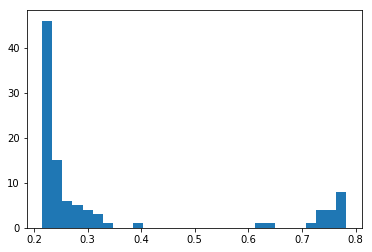

In [21]:
plt.hist([p_err(predictions[1],test_set[1]) for predictions in test_set_predictions],bins=30)

In [26]:
# create dataset N=100
N = 1000
active_TSs = [rejection_method(TS,N) for TS in training_sets]

# apply NN on test set
test_set_predictions = [nearest_neighbor(test_set[0],TS) for TS in active_TSs]

# compute the mean error rate
mean_p_err = np.mean([p_err(predictions[1],test_set[1]) for predictions in test_set_predictions])
std_p_err = np.std([p_err(predictions[1],test_set[1]) for predictions in test_set_predictions])

# print results
print('===================================================================')
print('N = 100')
print('The mean error rate is %0.1f percent.'%(mean_p_err*100))
print('The standard devation of the error rate is %0.1f percent.'%(std_p_err*100))

N = 100
The mean error rate is 38.0 percent.
The standard devation of the error rate is 1.5 percent.


(array([13., 23., 35., 22.,  7.]),
 array([0.348 , 0.3614, 0.3748, 0.3882, 0.4016, 0.415 ]),
 <a list of 5 Patch objects>)

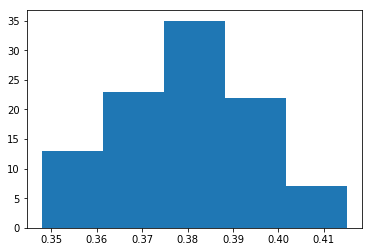

In [31]:
plt.hist([p_err(predictions[1],test_set[1]) for predictions in test_set_predictions],bins=5)

The predicted error rate of 35% is within the error of the monte carlo. For $N=100$, we also get an error rate within one $\sigma$ to 35%, but with a smaller standard deviation than before.  